In [1]:
import os


import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression as LR

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/novel_arm_activity"
os.makedirs(figdir, exist_ok=True)

In [3]:
class ActivityRate:
    
    def __init__(self, days = np.arange(6), pos_bin=False, pos_avg = True, block = 5, cell_avg=True, novel_only = False, fam_only=False, t_post=40):
        
        self.ko_mice = ko_mice
        self.ctrl_mice = ctrl_mice
        
        self.days = days
        self.n_days = days.shape[0]
        
        self.pos_bin = pos_bin
        self.pos_avg = pos_avg
        self.block = block
        self.cell_avg = cell_avg
        self.novel_only = novel_only
        self.fam_only = fam_only
        self.t_post = t_post
        self.df = None
        
        self.ko_data = self.mouse_loop(ko_mice)
        self.ctrl_data = self.mouse_loop(ctrl_mice)
        self.make_dataframe()
        
    @staticmethod
    def get_act_rate(sess, block=5, pos_bin=False, pos_avg = True, t_post = 40, cell_avg = True, novel_only = False, fam_only=False):
        '''
        
        
        '''
        
        last_block_ind = np.argwhere(sess.trial_info['block_number']==block)[0][0]
#         last_trial_ind = np.argwhere(sess.trial_info['block_number'])
        lr = np.zeros([t_post,])*np.nan
        _lr = sess.trial_info['LR'][last_block_ind:last_block_ind+t_post]
        lr[:_lr.shape[0]]=_lr
        
        if pos_bin:
            if pos_avg:
                
                mu = np.zeros([t_post,])*np.nan
                speed = np.zeros([t_post,])*np.nan
                
            
                baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind,:,:]
                tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]
                if novel_only:
                    tmat = tmat[_lr==sess.novel_arm,:,:]
                
                if fam_only:
                    tmat = tmat[_lr==-1*sess.novel_arm,:,:]
                    
                

                baseline_mu = (np.nanmean(baseline_tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()
                
                mu[:tmat.shape[0]] = (np.nanmean(tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()

                _baseline_speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind-10:last_block_ind, :], axis=-1)
                _speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:],axis=-1)/_baseline_speed.mean(axis=0,keepdims=True)
                if novel_only:
                    _speed = _speed[_lr==sess.novel_arm]
                    
                if fam_only:
                    _speed = _speed[_lr==-1*sess.novel_arm]
                    
                speed[:tmat.shape[0]] = _speed #np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post, :], axis=-1)/_baseline_speed.mean(keepdims=True)
                
                baseline_speed = _baseline_speed/_baseline_speed.mean()
            else:
                
                

                speed = np.zeros([t_post, sess.trial_matrices['speed'].shape[1]])*np.nan
                
                if cell_avg:
                    mu = np.zeros([t_post, sess.trial_matrices['spks'].shape[1]])*np.nan
                    baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind, :, :] +1E-5
                    tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]
                    if novel_only:
                        tmat = tmat[_lr==sess.novel_arm,:,:]
                


                    baseline_mu = np.nanmean(baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    
                    mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    
                else:
                    mu = np.zeros([t_post, *sess.trial_matrices['spks'].shape[1:]])*np.nan
                    baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind, :, :] +1E-5
                    tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]


    #                 baseline_mu = np.nanmean(baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    baseline_mu = baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True)
                    mu[:tmat.shape[0], :, :] = tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)

                
                _baseline_speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind-10:last_block_ind, :], axis=-1)
                _speed = sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:]/_baseline_speed.mean(axis=0,keepdims=True)
                if novel_only:
                    _speed = _speed[_lr==sess.novel_arm,:]
                speed[:tmat.shape[0], :] = _speed #sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:]/_baseline_speed.mean(axis=0,keepdims=True)
                
                baseline_speed = _baseline_speed/_baseline_speed.mean(axis=0, keepdims=True)
      
            
        else:
            
            # TODO: 
            _baseline_mu = np.zeros([10,sess.timeseries['spks'].shape[0]])*np.nan
            mu = np.zeros([t_post,sess.timeseries['spks'].shape[0]])*np.nan
            
            _baseline_speed = np.zeros([10,])*np.nan
            speed = np.zeros([t_post,])*np.nan
            
            baseline_starts, baseline_stops = sess.trial_start_inds[last_block_ind-10:last_block_ind], sess.teleport_inds[last_block_ind-10:last_block_ind]
            for i, (start, stop) in enumerate(zip(baseline_starts, baseline_stops)):
                _baseline_mu[i,:] = sess.timeseries['spks'][:,start:stop].mean(axis=-1)
                _baseline_speed[i] = sess.timeseries['speed'][0,start:stop].mean()
            
            starts, stops = sess.trial_start_inds[last_block_ind:last_block_ind+t_post], sess.teleport_inds[last_block_ind:last_block_ind+t_post]
            for i, (start, stop) in enumerate(zip(starts,stops)):
                mu[i,:] = sess.timeseries['spks'][:,start:stop].mean(axis=-1)
                speed[i] = sess.timeseries['speed'][0,start:stop].mean()
            
            
            baseline_mu = (_baseline_mu/_baseline_mu.mean(axis=0,keepdims=True)).mean(axis=-1) 
            mu = (mu/_baseline_mu.mean(axis=0,keepdims=True)).mean(axis=-1)
            
            
            baseline_speed = _baseline_speed/_baseline_speed.mean()
            speed /= _baseline_speed.mean()
#             print(speed.shape)
            
        return mu, baseline_mu, speed, baseline_speed, lr
    
    
    def mouse_loop(self, mice):
        
        d= {}
        for mouse in mice:
            d[mouse] = {'mu': [], 'baseline_mu': [], 'speed': [], 'baseline_speed': [], 'famnov': [], 'place_cell_info': []}
            for day in self.days:
                sess = u.load_single_day(mouse, day, verbose=False)
                mu, baseline_mu, speed, baseline_speed, lr = self.get_act_rate(sess, block=self.block, pos_bin = self.pos_bin, 
                                                                               pos_avg = self.pos_avg, cell_avg = self.cell_avg, 
                                                                               novel_only = self.novel_only, fam_only = self.fam_only,
                                                                              t_post = self.t_post)
                d[mouse]['mu'].append(mu)
                d[mouse]['baseline_mu'].append(baseline_mu)
                d[mouse]['speed'].append(speed)
                d[mouse]['baseline_speed'].append(baseline_speed)
                d[mouse]['famnov'].append(lr*sess.novel_arm) # 1 = novel, -1 familiar
                d[mouse]['place_cell_info'].append(sess.place_cell_info)
                
        return d
    
    
    
    @staticmethod
    def make_plot_arr(data_dict, day):
        
        mu, baseline_mu, speed, baseline_speed, lr = [], [], [], [], []
        for mouse in data_dict.keys():
            mu.append(data_dict[mouse]['mu'][day])
            baseline_mu.append(data_dict[mouse]['baseline_mu'][day])
            speed.append(data_dict[mouse]['speed'][day])
            baseline_speed.append(data_dict[mouse]['baseline_speed'][day])
            lr.append(data_dict[mouse]['famnov'][day])
            
        return np.array(mu), np.array(baseline_mu), np.array(speed), np.array(baseline_speed), np.array(lr)
    
    def make_dataframe(self):
        self.df = pd.DataFrame({'ko': [],
                          'day': [],
                          'dz': [],
                          'day_x_ko': [],
                          'mu': [],
                          'speed': [],
                          'mouse': [],
                          'm': [],
                          'intercept': [],
                          })
        days_z = sp.stats.zscore(self.days)
        for m, mouse in enumerate(self.ctrl_mice):
            for day, dz  in zip(self.days, days_z):
                for trial in np.argwhere(~np.isnan(self.ctrl_data[mouse]['mu'][day])):
                    print(self.ctrl_data[mouse]['mu'][day][trial][0])
                    self.df = self.df.append({'ko': 0,
                                    'day': day,
                                    'day_x_ko': 0,
                                    'mu': self.ctrl_data[mouse]['mu'][day][trial][0],
                                    'speed': self.ctrl_data[mouse]['speed'][day][trial][0],
                                    'day': day,
                                    'dz': dz,
                                    'mouse': mouse,
                                    'm': m,
                                    'intercept': 1,
                                   }, ignore_index=True)
                                    
        for m, mouse in enumerate(self.ko_mice):
            for day, dz in zip(self.days, days_z):
                for trial in np.argwhere(~np.isnan(self.ko_data[mouse]['mu'][day])):
                    
                    self.df = self.df.append({'ko': 1,
                                    'day': day,
                                    'day_x_ko': dz,
                                    'mu': self.ko_data[mouse]['mu'][day][trial][0],
                                    'speed': self.ko_data[mouse]['speed'][day][trial][0],
                                    'day': day,
                                    'dz': dz,
                                    'mouse': mouse,
                                    'm': m + len(self.ctrl_mice),
                                    'intercept': 1,
                                   }, ignore_index=True)
                                    
               

    
    def mixed_anova(self, verbose = True, group_t = True, day_t = True):
        
        
        
        results = {}
        aov = mixed_anova(data=self.df[self.df['day']<5], dv='mu', between='ko', within='day', subject='m')
        results['anova'] = aov
        if verbose:
            print('Mixed design ANOVA results')
            print(aov)

        if group_t:
            ko_ctrl_tukey = pairwise_ttests(data=self.df, dv='mu', between='ko')
            results['ko_ctrl_tukey'] = ko_ctrl_tukey
            if verbose:
                print('PostHoc Tukey: KO vs Ctrl')
                print(ko_ctrl_tukey)

        if day_t:
            day_stats = []
            print('PostHov Tukey on each day')
            for day in self.days:
                print('Day %d' % day)
                stats = pairwise_ttests(data=self.df[self.df['day'] == day], dv='mu', between='ko')
                day_stats.append(stats)
                if verbose:
                    print(stats)
            results['day_tukey'] = day_stats

        return results
            
            
    
    @staticmethod
    def mu_sem(arr, axis=0):
        return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
        
    
    def plot_activity_rates(self):
        
        
        fig_mu,ax_mu = plt.subplots(2, self.n_days, sharey=True, sharex = True, figsize= [5 * self.n_days, 10])
        fig_mu.suptitle('Activty Rate')
        fig_speed,ax_speed = plt.subplots(2, self.n_days, sharey=True, sharex=True, figsize= [5 * self.n_days, 10])
        fig_speed.suptitle('Speed')
        
        x_baseline = np.arange(-10,0)
        x_ = np.arange(0,self.t_post)
        for d, day in enumerate(self.days):
            ko_mu, ko_baseline_mu, ko_speed, ko_baseline_speed, ko_lr = self.make_plot_arr(self.ko_data, d)
            ctrl_mu, ctrl_baseline_mu, ctrl_speed, ctrl_baseline_speed, ctrl_lr = self.make_plot_arr(self.ctrl_data, d)
        
            # baseline mu
#             ax_mu[0,d].plot(x_baseline, ko_baseline_mu.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_baseline_mu)
            ax_mu[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_mu[0,d].plot(x_baseline, ctrl_baseline_mu.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_baseline_mu)
            ax_mu[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='black', alpha = .3)
            
            # mu
#             ax_mu[0,d].plot(x_, ko_mu.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_mu)
            ax_mu[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_mu[0,d].plot(x_, ctrl_mu.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_mu)
            ax_mu[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color = 'black', alpha = .3)
            
            # baseline_speed
#             ax_speed[0,d].plot(x_baseline, ko_baseline_speed.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_baseline_mu)
            ax_speed[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_speed[0,d].plot(x_baseline, ctrl_baseline_speed.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_baseline_speed)
            ax_speed[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='black', alpha = .3)
            
            # speed
#             ax_speed[0,d].plot(x_, ko_speed.T , color= 'red')
#             
            _mu, _sem = self.mu_sem(ko_speed)
            ax_speed[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_speed[0,d].plot(x_, ctrl_speed.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_speed)
            ax_speed[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color = 'black', alpha = .3)
            
            for r in [0,1]:
                ax_mu[r, d].spines['top'].set_visible(False)
                ax_mu[r, d].spines['right'].set_visible(False)
                
                ax_speed[r, d].spines['top'].set_visible(False)
                ax_speed[r, d].spines['right'].set_visible(False)
        return (fig_mu, ax_mu), (fig_speed, ax_speed)

In [4]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=True, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


1.4586465087531761
1.4205447648375615
1.478777972514754
1.310076793856318
1.4064228878990581
1.4004882866931172
1.3607986248418944
1.3381500587577673
1.3818490544930555
1.3900337511172989
1.303570482981832
1.368726464957366
1.3989661582333917
1.4696896008615656
1.527950666109663
1.459786572138416
1.5159328966379975
1.3297254320987328
1.3179627872181752
1.3449606293483796
1.480955014268932
1.263782143665745
1.3029725065427304
1.402868431018119
1.4748842779813607
1.373910226652732
1.2882678510812884
1.4196929641252691
1.4391134965103265
1.4117389082821885
1.3587371678699833
1.4816364167953378
1.3128808653922932
1.3718699818373525
1.3193167419891831
1.3785525748749952
1.430206696429643
1.3425189387720993
1.2713221586973575
1.5304134549327022
1.4360018494014613
1.2552972198757044
1.3503005591743897
1.2927209285470702
1.2566900382239852
1.256279569567591
1.2995963741572802
1.4260594928618817
1.2423002158633114
1.279456730039841
1.2175565025190676
1.2699631473638529
1.2225749689018695
1.2617

In [5]:
ar.mixed_anova()

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc  p-GG-corr  \
0           ko  0.944430    1   14  0.944430  33.658334  0.000046        NaN   
1          day  0.142475    4   56  0.035619   4.217880  0.004696   0.021101   
2  Interaction  0.051437    4   56  0.012859   1.522768  0.208020        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.706242       NaN        NaN       NaN       NaN  
1  0.231524  0.577483      False  0.151916  0.002867  
2  0.098099       NaN        NaN       NaN       NaN  
PostHoc Tukey: KO vs Ctrl
  Contrast    A    B  Paired  Parametric         T          dof alternative  \
0       ko  0.0  1.0   False        True  26.92083  1638.368443   two-sided   

           p-unc        BF10    hedges  
0  1.748772e-132  5.586e+128  1.231757  
PostHov Tukey on each day
Day 0
  Contrast    A    B  Paired  Parametric          T         dof alternative  \
0       ko  0.0  1.0   False        True  11.770166  2

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc  p-GG-corr  \
 0           ko  0.944430    1   14  0.944430  33.658334  0.000046        NaN   
 1          day  0.142475    4   56  0.035619   4.217880  0.004696   0.021101   
 2  Interaction  0.051437    4   56  0.012859   1.522768  0.208020        NaN   
 
         np2       eps sphericity   W-spher   p-spher  
 0  0.706242       NaN        NaN       NaN       NaN  
 1  0.231524  0.577483      False  0.151916  0.002867  
 2  0.098099       NaN        NaN       NaN       NaN  ,
 'ko_ctrl_tukey':   Contrast    A    B  Paired  Parametric         T          dof alternative  \
 0       ko  0.0  1.0   False        True  26.92083  1638.368443   two-sided   
 
            p-unc        BF10    hedges  
 0  1.748772e-132  5.586e+128  1.231757  ,
 'day_tukey': [  Contrast    A    B  Paired  Parametric          T         dof alternative  \
  0       ko  0.0  1.0   False        True  11.770166  290.648011   two-sided   
 

In [6]:
df = ar.df[ar.df['day']<5]
lmm_res = MixedLM(df['mu'], df[['ko',  'speed', 'intercept']], df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mu      
No. Observations: 1375    Method:             REML    
No. Groups:       16      Scale:              0.0142  
Min. group size:  36      Log-Likelihood:     938.6824
Max. group size:  101     Converged:          Yes     
Mean group size:  85.9                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.216    0.037 -5.920 0.000 -0.288 -0.145
speed       -0.080    0.022 -3.624 0.000 -0.124 -0.037
intercept    1.437    0.031 45.623 0.000  1.375  1.498
Group Var    0.005    0.017                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
lmm_resf.pvalues

ko           3.220785e-09
speed        2.902965e-04
intercept    0.000000e+00
Group Var    1.067321e-02
dtype: float64

In [8]:
ar.ko_data[ko_mice[0]]['mu'][0]

array([1.26309689, 1.14639716, 1.1331117 , 1.18621341, 1.1300322 ,
       1.09828587, 1.1027631 , 1.17769775, 1.18052135, 1.19246134,
       1.15651086, 1.18609504, 1.16757112, 1.15798525, 1.1088122 ,
       1.18933241, 1.12010781, 1.13211509, 1.11595985, 1.14900866,
       1.05009752, 1.06955547,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

Day 0
-3.588444930354749 0.002965711578170199
Day 1
-4.3468008915475655 0.0006701167736877461
Day 2
-4.782723297712312 0.00029189495842137867
Day 3
-3.6094362869168606 0.002844722456766595
Day 4
-3.7183726971911777 0.0022924162028033924
Day 5
-2.315863114179144 0.036242641424426875


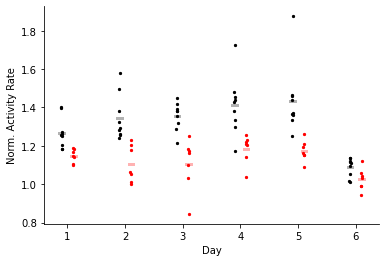

In [9]:
fig, ax = plt.subplots()
for day in ar.days:
   
    
    
    ctrl = np.array([np.nanmean(ar.ctrl_data[mouse]['mu'][day]) for mouse in ar.ctrl_mice])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ar.ctrl_mice)), ctrl, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    ko = np.array([np.nanmean(ar.ko_data[mouse]['mu'][day]) for mouse in ar.ko_mice])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ar.ko_mice)), ko, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    
    
    t,p = sp.stats.ttest_ind(ko,ctrl)
    print('Day', day)
    print(t,p)
    

ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,"novel_activity_rate_summary.pdf"),format='pdf')

<ipython-input-3-4bef6004a46b>:259: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')


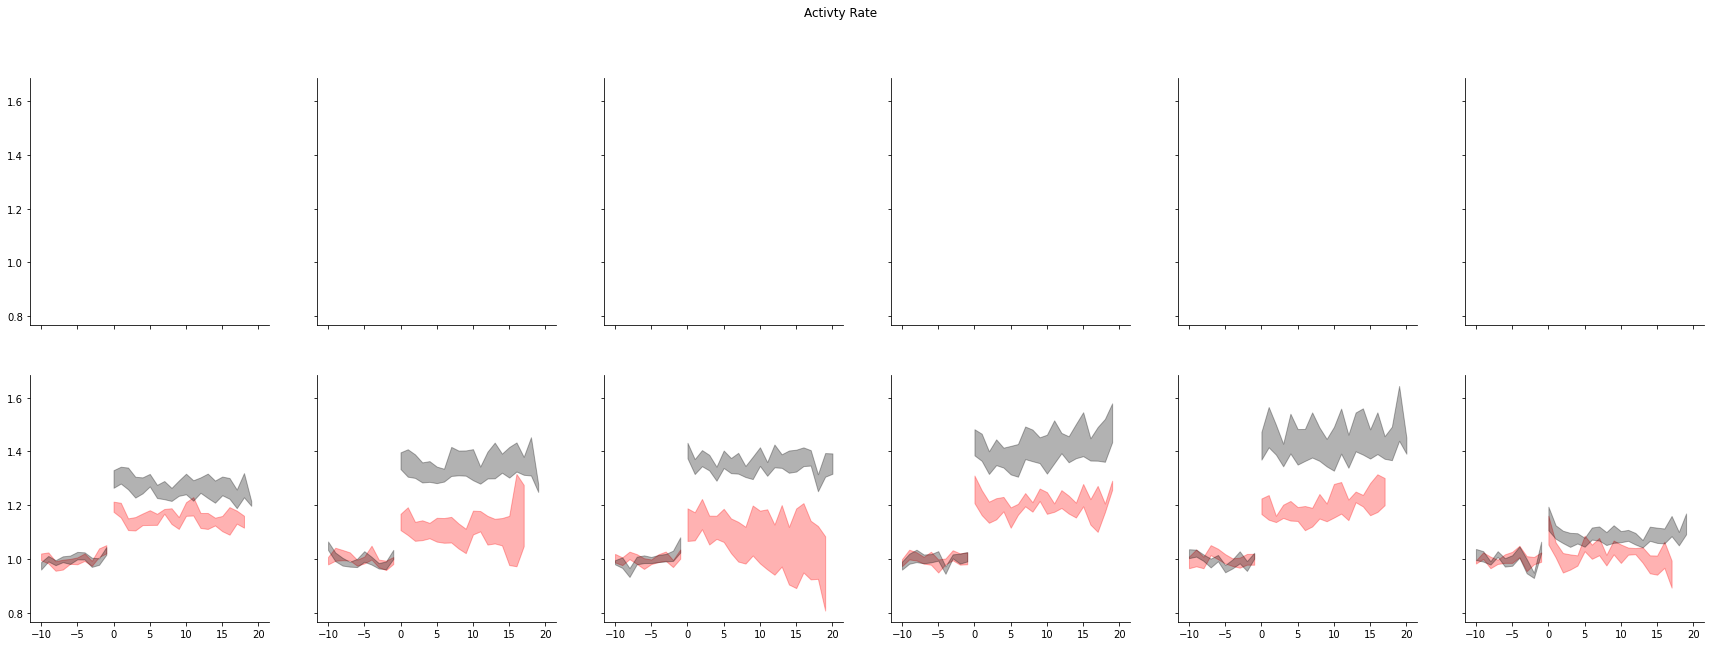

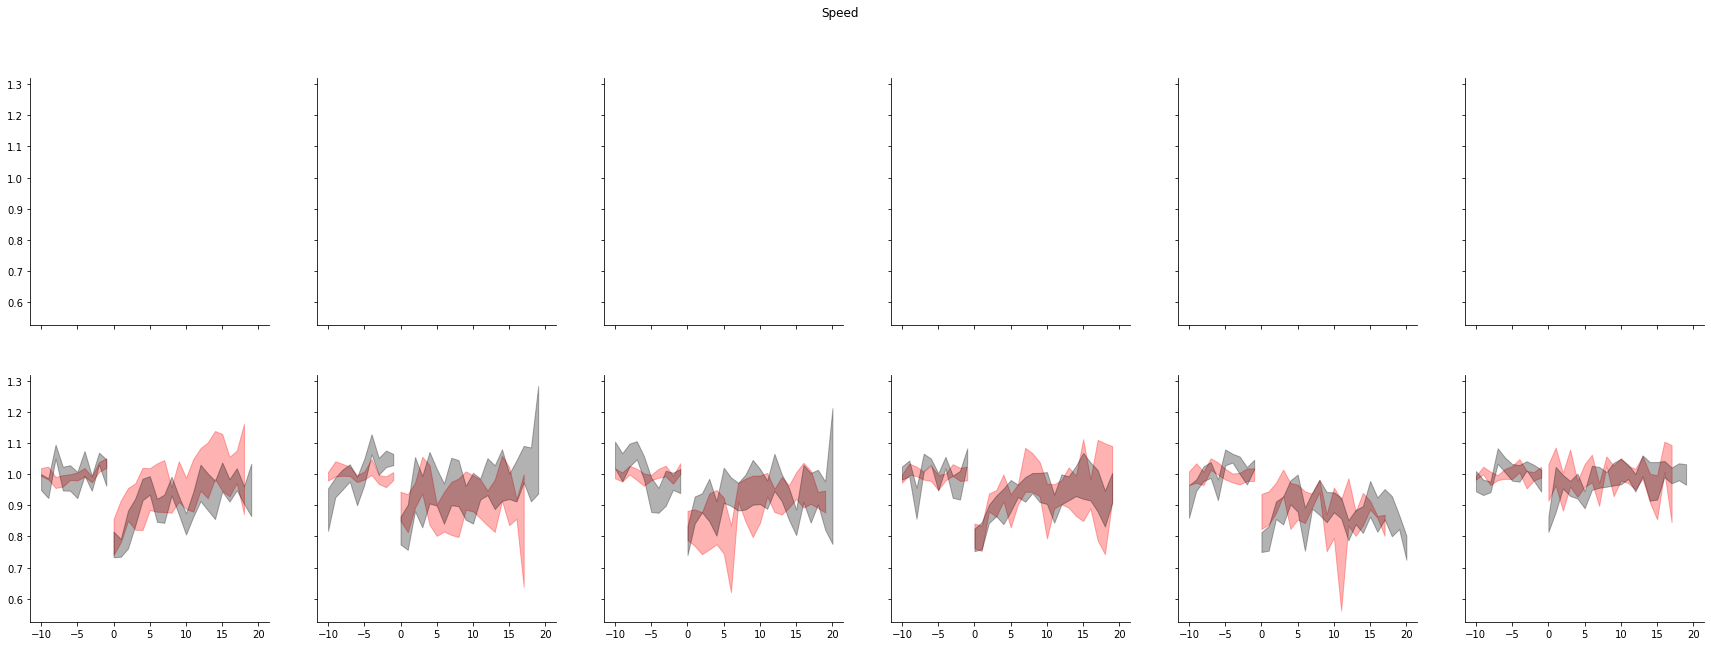

In [10]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
fig_mu.savefig(os.path.join(figdir,'novel_only_block5_activity.pdf'),format='pdf')
fig_speed.savefig(os.path.join(figdir,'novel_only_block5_speed.pdf'),format='pdf')


(9, 40)


ValueError: x and y must have same first dimension, but have shapes (30,) and (9,)

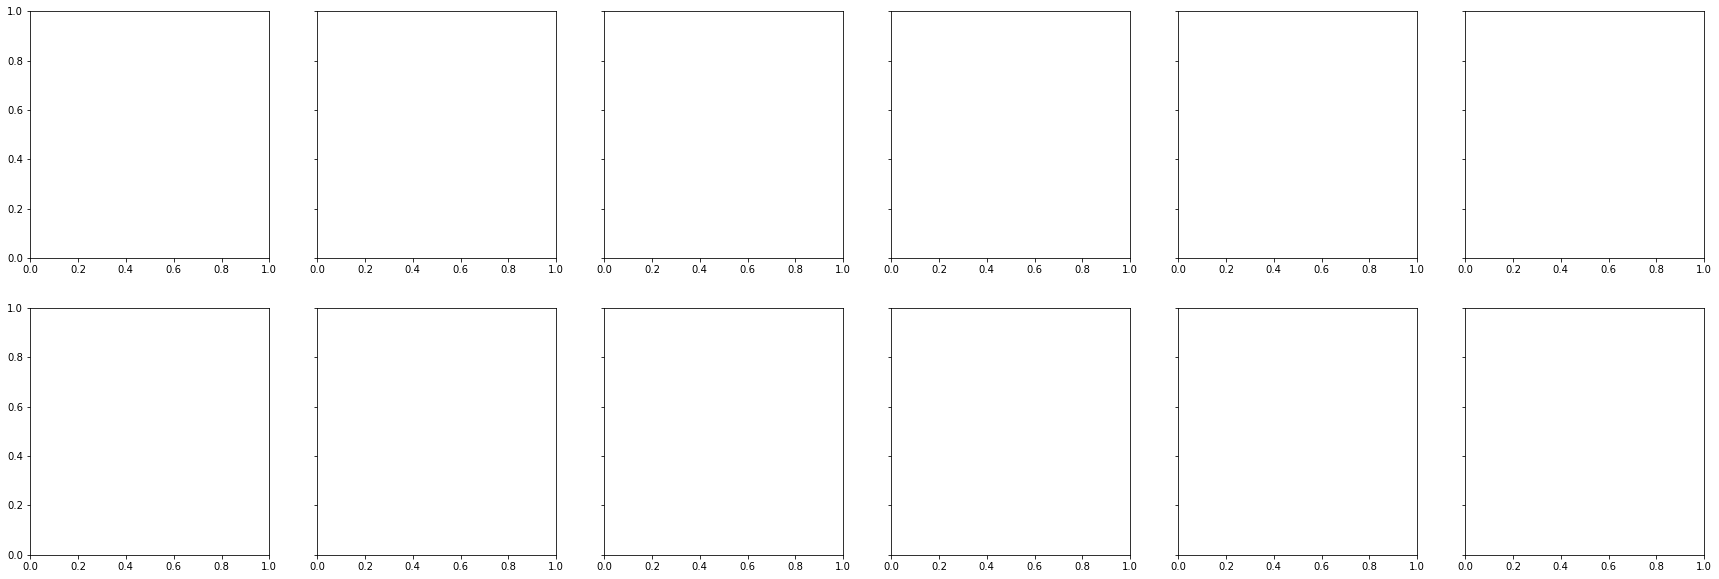

In [19]:
fig,ax = plt.subplots(2,6, figsize = [30,10], sharey=True)

x = np.arange(30)
for day in range(6):

    ctrl_mu, _, speed, _, ctrl_lr = ar.make_plot_arr(ar.ctrl_data,day)
    print(ctrl_mu.shape)
    ko_mu, _, speed, _, ko_lr = ar.make_plot_arr(ar.ko_data,day)

    ax[0,day].plot(x, np.nanmean(ctrl_mu,axis=1).T, color='black')
    mu, sem = ar.mu_sem(np.nanmean(ctrl_mu, axis=1))
    ax[1,day].fill_between(x, mu-sem, mu+sem, alpha = .3, color='black')

    ax[0,day].plot(x, np.nanmean(ko_mu,axis=1).T, color='red')
    mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=1))
    ax[1,day].fill_between(x, mu-sem, mu+sem, alpha = .3, color='red')
    
    for r in range(2):
        ax[r,day].spines['top'].set_visible(False)
        ax[r,day].spines['right'].set_visible(False)
        
        if day ==0:
            ax[r,day].set_xlabel('Position')
            ax[r,day].set_ylabel('Norm Activity Rate')
# fig.savefig(os.path.join(figdir,'activityrate_vs_position.pdf'), format='pdf')

In [20]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=True, fam_only=False,cell_avg=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


1.4586465087531761
1.4205447648375615
1.478777972514754
1.310076793856318
1.4064228878990581
1.4004882866931172
1.3607986248418944
1.3381500587577673
1.3818490544930555
1.3900337511172989
1.303570482981832
1.368726464957366
1.3989661582333917
1.4696896008615656
1.527950666109663
1.459786572138416
1.5159328966379975
1.3297254320987328
1.3179627872181752
1.3449606293483796
1.480955014268932
1.263782143665745
1.3029725065427304
1.402868431018119
1.4748842779813607
1.373910226652732
1.2882678510812884
1.4196929641252691
1.4391134965103265
1.4117389082821885
1.3587371678699833
1.4816364167953378
1.3128808653922932
1.3718699818373525
1.3193167419891831
1.3785525748749952
1.430206696429643
1.3425189387720993
1.2713221586973575
1.5304134549327022
1.4360018494014613
1.2552972198757044
1.3503005591743897
1.2927209285470702
1.2566900382239852
1.256279569567591
1.2995963741572802
1.4260594928618817
1.2423002158633114
1.279456730039841
1.2175565025190676
1.2699631473638529
1.2225749689018695
1.2617

In [26]:
ar.ctrl_data['mCherry9']['mu'][1]

array([1.51694899, 1.66056417, 1.58608295, 1.48549693, 1.5428944 ,
       1.40465663, 1.41495537, 1.7115644 , 1.56879531, 1.57857312,
       1.53157662, 1.46302235, 1.60992446, 1.80259509, 1.51585397,
       1.76965193, 1.68520633, 1.42391066, 1.73677216,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [62]:
ar = ActivityRate(days = np.arange(6), block=3, pos_bin=True, pos_avg=True, novel_only=False, fam_only=True, t_post=20)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


1.3124722393076196
1.1935963349715795
1.128282363598935
1.0567537698251797
1.0491673643983943
1.0993334285996181
1.055176596569367
0.9867096089570296
1.009450433255791
1.0248359649342766
1.1116889086675612
1.065461170100755
1.0653881749416714
1.0445346909501103
1.0413621879259711
1.1140378358505343
1.0309742635265868
1.0354098278177912
1.0162098199705865
1.0513060799703986
1.814184878835268
1.2935554545713719
1.099712452354679
1.0189251631038738
1.0366503418302877
0.978114212997257
1.0800155954485569
1.02751478718267
1.111020705573135
0.9951021582272593
1.0599638365180344
0.9937321148216401
1.0182939592653883
1.058431677156469
0.993797093315
1.1507843303771548
1.2354674574238367
1.2678073047633225
1.0671659801364517
1.1272100065723272
1.4784563673427005
1.1218084839642997
1.0531494246302802
0.9740436374512148
0.9702170964427498
1.0344269049574617
0.9773340518784435
0.9644054938604859
0.926488896910328
0.9374795840989372
0.8958591605931847
0.9898172352891873
1.0302245972552744
1.0060605

<ipython-input-50-960f3242b7ee>:259: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-50-960f3242b7ee>:259: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-50-960f3242b7ee>:259: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-50-960f3242b7ee>:259: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')


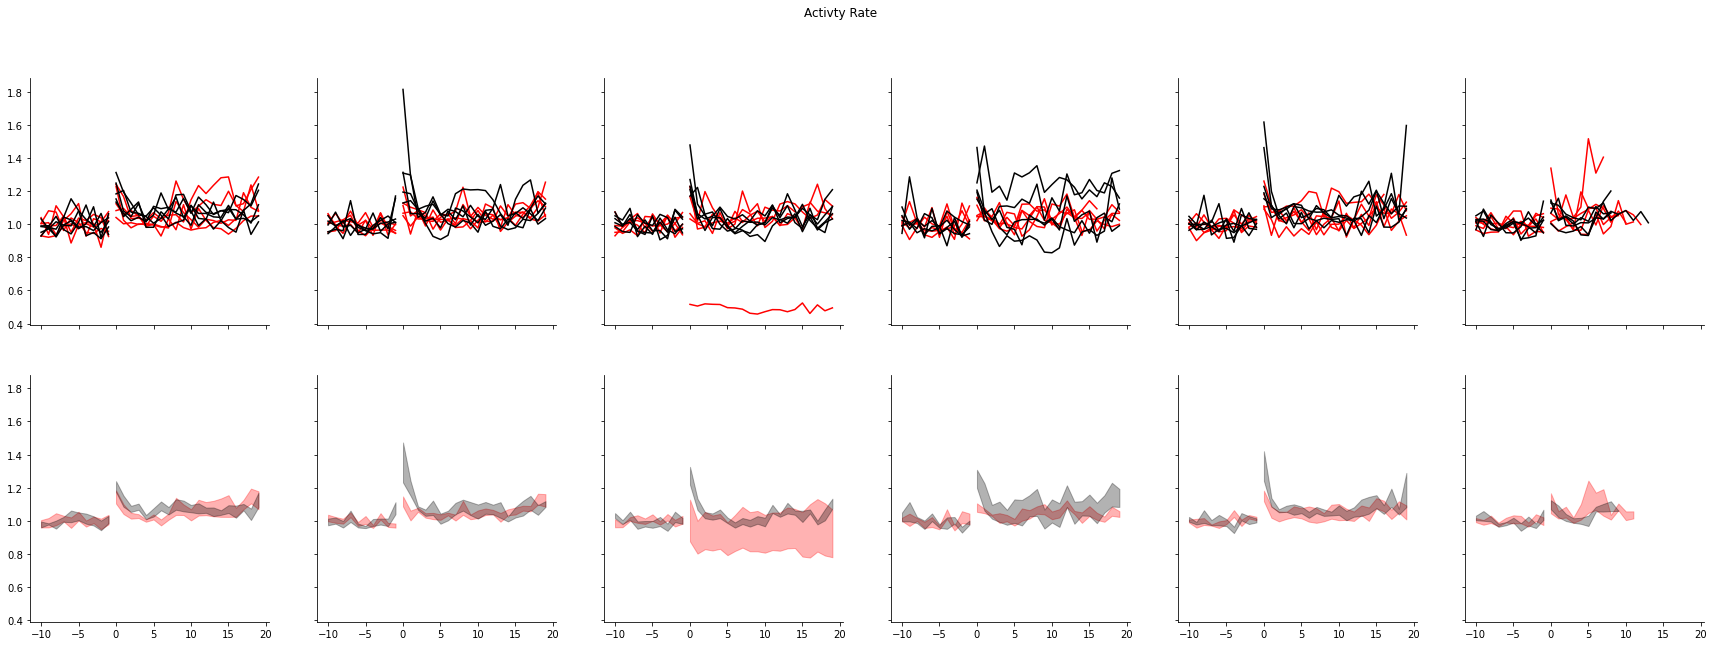

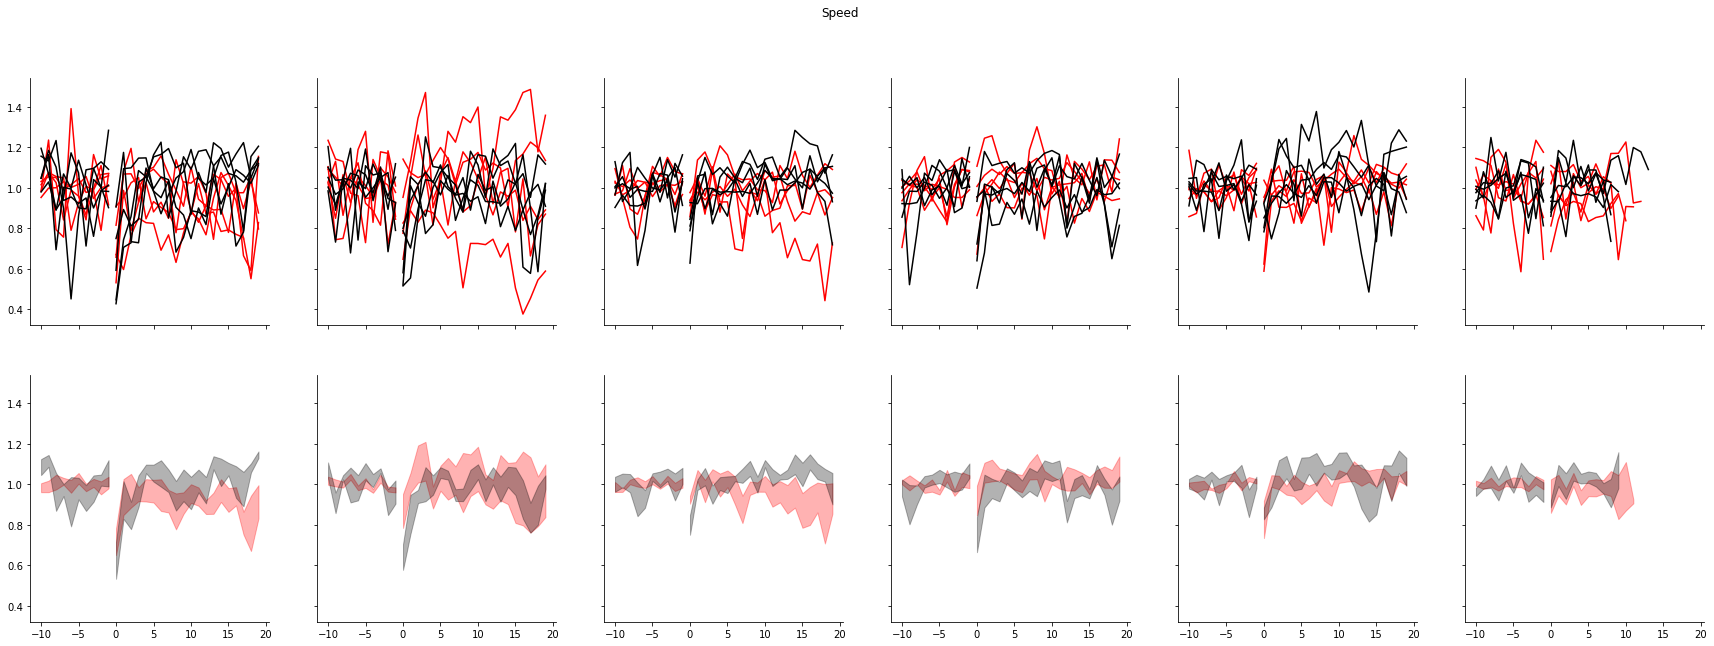

In [65]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
fig_mu.savefig(os.path.join(figdir,'fam_only_block3_activity.pdf'),format='pdf')
fig_speed.savefig(os.path.join(figdir,'fam_only_block3_speed.pdf'),format='pdf')


In [66]:
ar.mixed_anova()

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.024344    1    8  0.024344  2.669195  0.140949  0.250178   
1          day  0.047642    4   32  0.011911  1.362174  0.268900  0.145498   
2  Interaction  0.010809    4   32  0.002702  0.309041  0.869784  0.037193   

       eps  
0      NaN  
1  0.44817  
2      NaN  
PostHoc Tukey: KO vs Ctrl
  Contrast    A    B  Paired  Parametric       T          dof       Tail  \
0       ko  0.0  1.0   False        True  5.4677  1031.530632  two-sided   

          p-unc       BF10    hedges  
0  5.718680e-08  1.438e+05  0.331375  
PostHov Tukey on each day
Day 0
  Contrast    A    B  Paired  Parametric         T         dof       Tail  \
0       ko  0.0  1.0   False        True  1.345555  183.919761  two-sided   

      p-unc  BF10    hedges  
0  0.180103  0.36  0.190984  
Day 1
  Contrast    A    B  Paired  Parametric         T    dof       Tail  \
0       ko  0.0  1.0   Fal

{'anova':         Source        SS  DF1  DF2        MS         F     p-unc       np2  \
 0           ko  0.024344    1    8  0.024344  2.669195  0.140949  0.250178   
 1          day  0.047642    4   32  0.011911  1.362174  0.268900  0.145498   
 2  Interaction  0.010809    4   32  0.002702  0.309041  0.869784  0.037193   
 
        eps  
 0      NaN  
 1  0.44817  
 2      NaN  ,
 'ko_ctrl_tukey':   Contrast    A    B  Paired  Parametric       T          dof       Tail  \
 0       ko  0.0  1.0   False        True  5.4677  1031.530632  two-sided   
 
           p-unc       BF10    hedges  
 0  5.718680e-08  1.438e+05  0.331375  ,
 'day_tukey': [  Contrast    A    B  Paired  Parametric         T         dof       Tail  \
  0       ko  0.0  1.0   False        True  1.345555  183.919761  two-sided   
  
        p-unc  BF10    hedges  
  0  0.180103  0.36  0.190984  ,
    Contrast    A    B  Paired  Parametric         T    dof       Tail  \
  0       ko  0.0  1.0   False        True  2.289

Day 0
-0.5725675318979053 0.582666806300073
Day 1
-1.5759041642588396 0.15369733406323013
Day 2
-0.8843316822645932 0.40231200530448363
Day 3
-0.834966003516193 0.4279658809910005
Day 4
-1.038495076889111 0.3294062098805841
Day 5
0.9057716141089039 0.3915197739896755


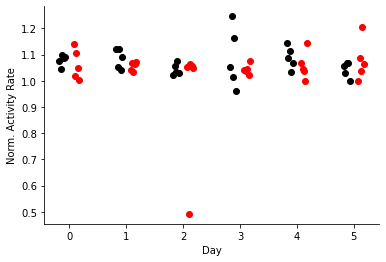

In [67]:
fig, ax = plt.subplots()
for day in ar.days:
    _ko = np.array([np.nanmean(ar.ko_data[mouse]['mu'][day]) for mouse in ar.ko_mice])
    _ctrl = np.array([np.nanmean(ar.ctrl_data[mouse]['mu'][day]) for mouse in ar.ctrl_mice])
    
    t,p = sp.stats.ttest_ind(_ko,_ctrl)
    print('Day', day)
    print(t,p)
    
    ax.scatter(0*_ko + np.linspace(-.1,.1, num=5) + 2*day+.25, _ko, color='red')
    ax.scatter(0*_ko + np.linspace(-.1,.1, num=5) + 2*day -.25 , _ctrl, color='black')
ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels([0,1,2,3,4,5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,"alldays_block3actrate.pdf"),format = 'pdf')

In [14]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=False, fam_only=True)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


1.4985501548773372
1.2750535169039987
1.3059497585062294
1.2951608297118762
1.1357098578818041
1.133514818643125
1.2523301338304451
1.1255509733238607
1.1726758133558493
1.1277951926126735
1.143579891975999
1.1129093541864619
1.0951624125162136
1.131541853418995
1.108573259849488
1.1404633432630567
1.0714799607239258
1.2164454609248734
1.2266814185510597
1.2320803032356282
1.2776568846302954
1.670050095763852
1.2058216793062828
1.1766124850822424
1.1710693669622056
1.4894886316289957
1.109703286939512
1.1018213226088485
1.110181024165522
1.555291296667205
1.4953987928636079
1.0953769652238388
1.140172663465747
1.2937262807593075
1.1577688579102894
1.1447444588811078
1.2372610773119397
1.1626309499260152
1.2381044561810637
1.1455184993269936
1.5132044599027366
1.1228374471261549
1.1722023094384075
1.0586500489500443
1.0836269478731453
1.0791843277960846
1.1059110046361136
1.0910861856144012
1.0281615670877753
1.1475473300339056
1.1293561104010397
1.41870627813825
1.1028151964059973
1.12

In [15]:
ar.mixed_anova()

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.162166    1    8  0.162166  18.142559  0.002764  0.693986   
1          day  0.002590    4   32  0.000648   0.297230  0.877574  0.035823   
2  Interaction  0.004857    4   32  0.001214   0.557371  0.695150  0.065133   

       eps  
0      NaN  
1  0.86936  
2      NaN  
PostHoc Tukey: KO vs Ctrl
  Contrast    A    B  Paired  Parametric          T          dof       Tail  \
0       ko  0.0  1.0   False        True  16.340504  1029.031486  two-sided   

          p-unc       BF10    hedges  
0  1.539021e-53  1.325e+50  0.949872  
PostHov Tukey on each day
Day 0
  Contrast    A    B  Paired  Parametric         T         dof       Tail  \
0       ko  0.0  1.0   False        True  7.127281  185.853984  two-sided   

          p-unc       BF10    hedges  
0  2.193783e-11  3.398e+08  1.020987  
Day 1
  Contrast    A    B  Paired  Parametric         T        dof       Ta

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0           ko  0.162166    1    8  0.162166  18.142559  0.002764  0.693986   
 1          day  0.002590    4   32  0.000648   0.297230  0.877574  0.035823   
 2  Interaction  0.004857    4   32  0.001214   0.557371  0.695150  0.065133   
 
        eps  
 0      NaN  
 1  0.86936  
 2      NaN  ,
 'ko_ctrl_tukey':   Contrast    A    B  Paired  Parametric          T          dof       Tail  \
 0       ko  0.0  1.0   False        True  16.340504  1029.031486  two-sided   
 
           p-unc       BF10    hedges  
 0  1.539021e-53  1.325e+50  0.949872  ,
 'day_tukey': [  Contrast    A    B  Paired  Parametric         T         dof       Tail  \
  0       ko  0.0  1.0   False        True  7.127281  185.853984  two-sided   
  
            p-unc       BF10    hedges  
  0  2.193783e-11  3.398e+08  1.020987  ,
    Contrast    A    B  Paired  Parametric         T        dof       Tail  \
  0       ko  0.0

Day 0
-3.0940522382061095 0.014798440653263455
Day 1
-3.1052421000823136 0.01454986178954686
Day 2
-3.6046067016582453 0.006935751194427933
Day 3
-2.6580898875290146 0.028890943459601786
Day 4
-3.0567293283215036 0.01566016737674903
Day 5
-2.1738772597234344 0.061446086292301735


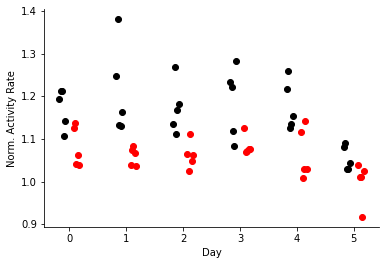

In [16]:
fig, ax = plt.subplots()
for day in ar.days:
    _ko = np.array([np.nanmean(ar.ko_data[mouse]['mu'][day]) for mouse in ar.ko_mice])
    _ctrl = np.array([np.nanmean(ar.ctrl_data[mouse]['mu'][day]) for mouse in ar.ctrl_mice])
    
    t,p = sp.stats.ttest_ind(_ko,_ctrl)
    print('Day', day)
    print(t,p)
    
    ax.scatter(0*_ko + np.linspace(-.1,.1, num=5) + 2*day+.25, _ko, color='red')
    ax.scatter(0*_ko + np.linspace(-.1,.1, num=5) + 2*day -.25 , _ctrl, color='black')
ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels([0,1,2,3,4,5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,"alldays_famactrate.pdf"),format = 'pdf')

<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-0af1b7fa4ae6>:257: RuntimeWarning: Mean of empt

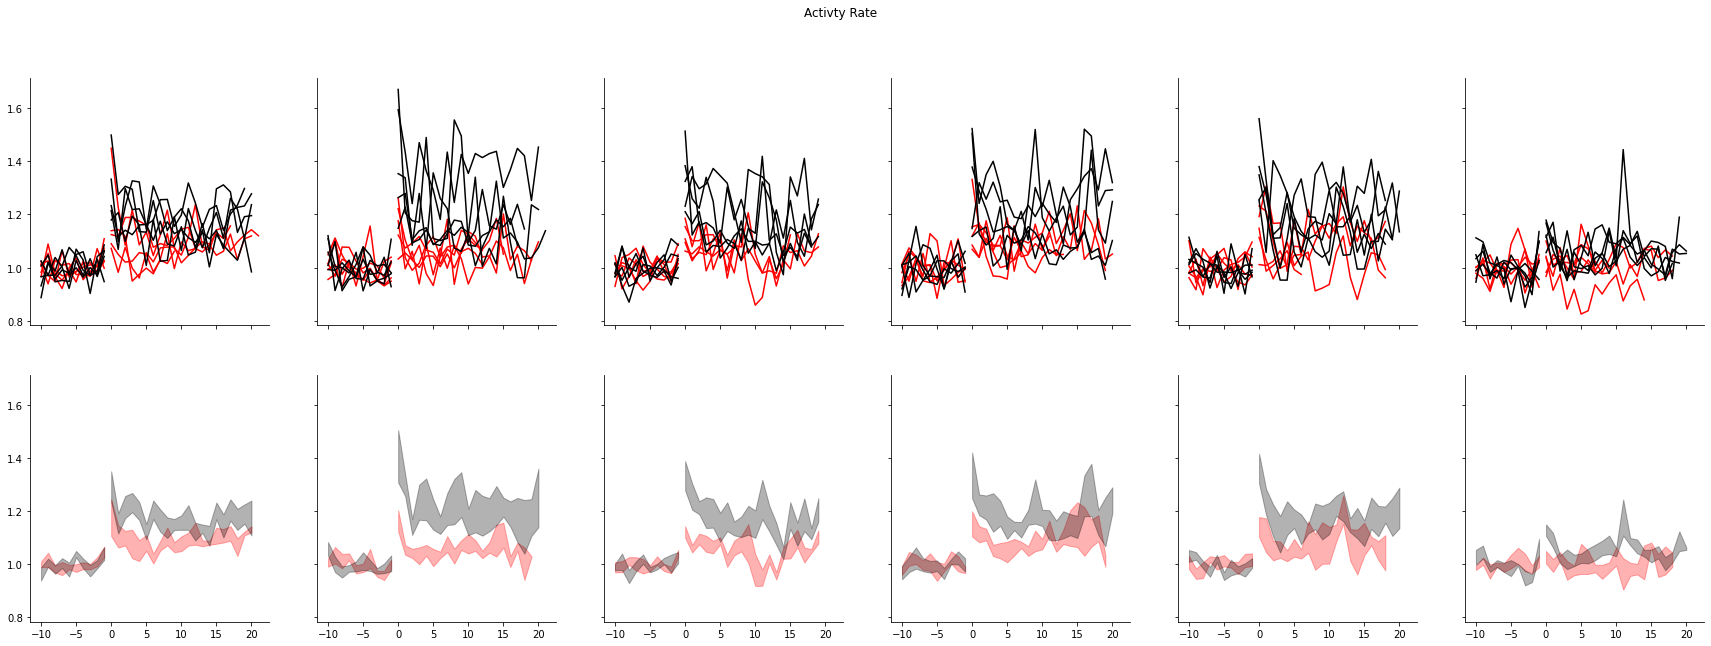

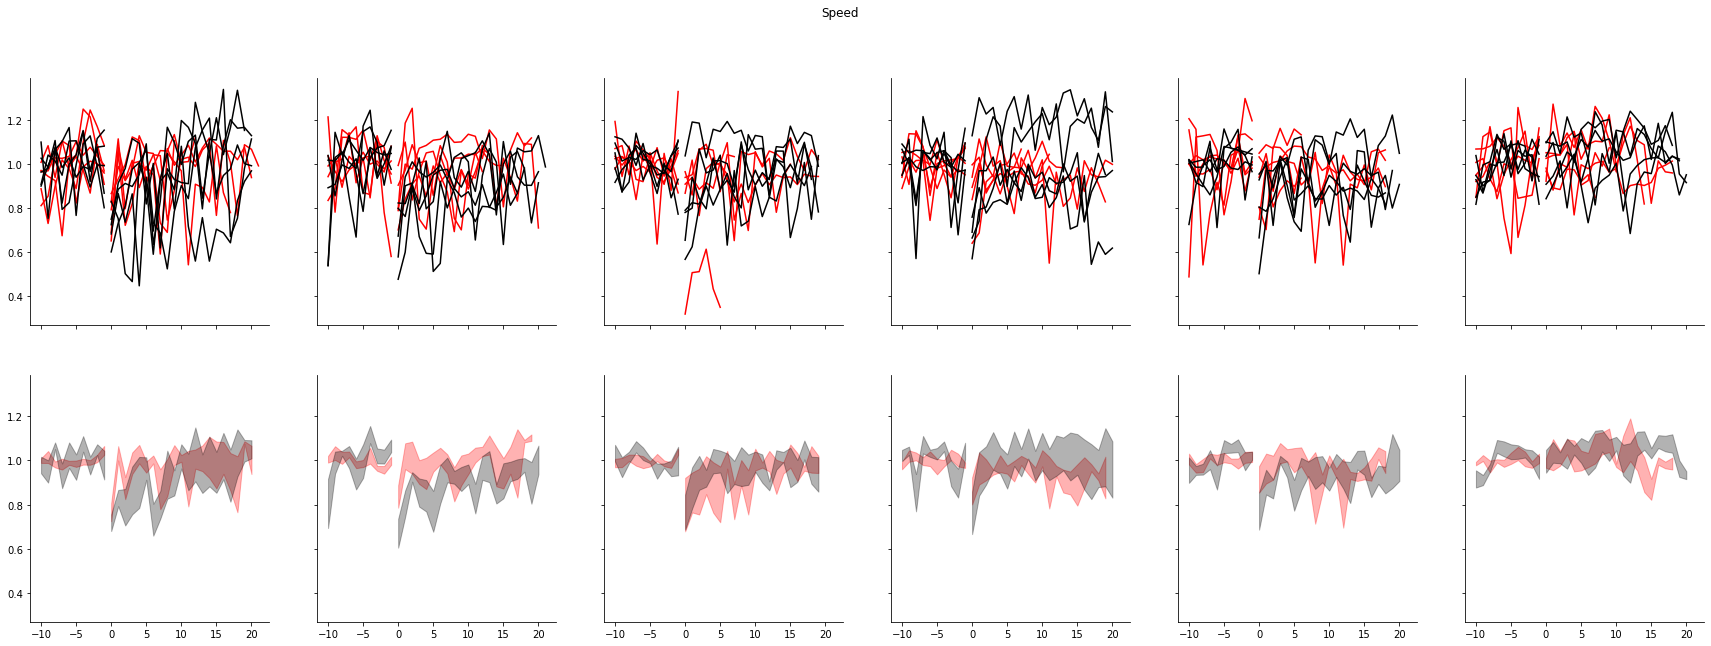

In [17]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
fig_mu.savefig(os.path.join(figdir,'fam_only_block5_activity.pdf'),format='pdf')
fig_speed.savefig(os.path.join(figdir,'fam_only_block5_speed.pdf'),format='pdf')

In [18]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=False, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


1.4985501548773372
1.2750535169039987
1.4586465087531761
1.4205447648375615
1.478777972514754
1.3059497585062294
1.310076793856318
1.2951608297118762
1.1357098578818041
1.4064228878990581
1.133514818643125
1.4004882866931172
1.3607986248418944
1.2523301338304451
1.3381500587577673
1.3818490544930555
1.1255509733238607
1.1726758133558493
1.3900337511172989
1.303570482981832
1.1277951926126735
1.143579891975999
1.1129093541864619
1.368726464957366
1.0951624125162136
1.3989661582333917
1.131541853418995
1.108573259849488
1.4696896008615656
1.1404633432630567
1.0714799607239258
1.527950666109663
1.2164454609248734
1.459786572138416
1.2266814185510597
1.5159328966379975
1.3297254320987328
1.3179627872181752
1.2320803032356282
1.2776568846302954
1.670050095763852
1.2058216793062828
1.1766124850822424
1.1710693669622056
1.3449606293483796
1.4894886316289957
1.480955014268932
1.263782143665745
1.109703286939512
1.3029725065427304
1.402868431018119
1.4748842779813607
1.1018213226088485
1.110181

<ipython-input-3-95d41453051a>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-95d41453051a>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-95d41453051a>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
<ipython-input-3-95d41453051a>:257: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')


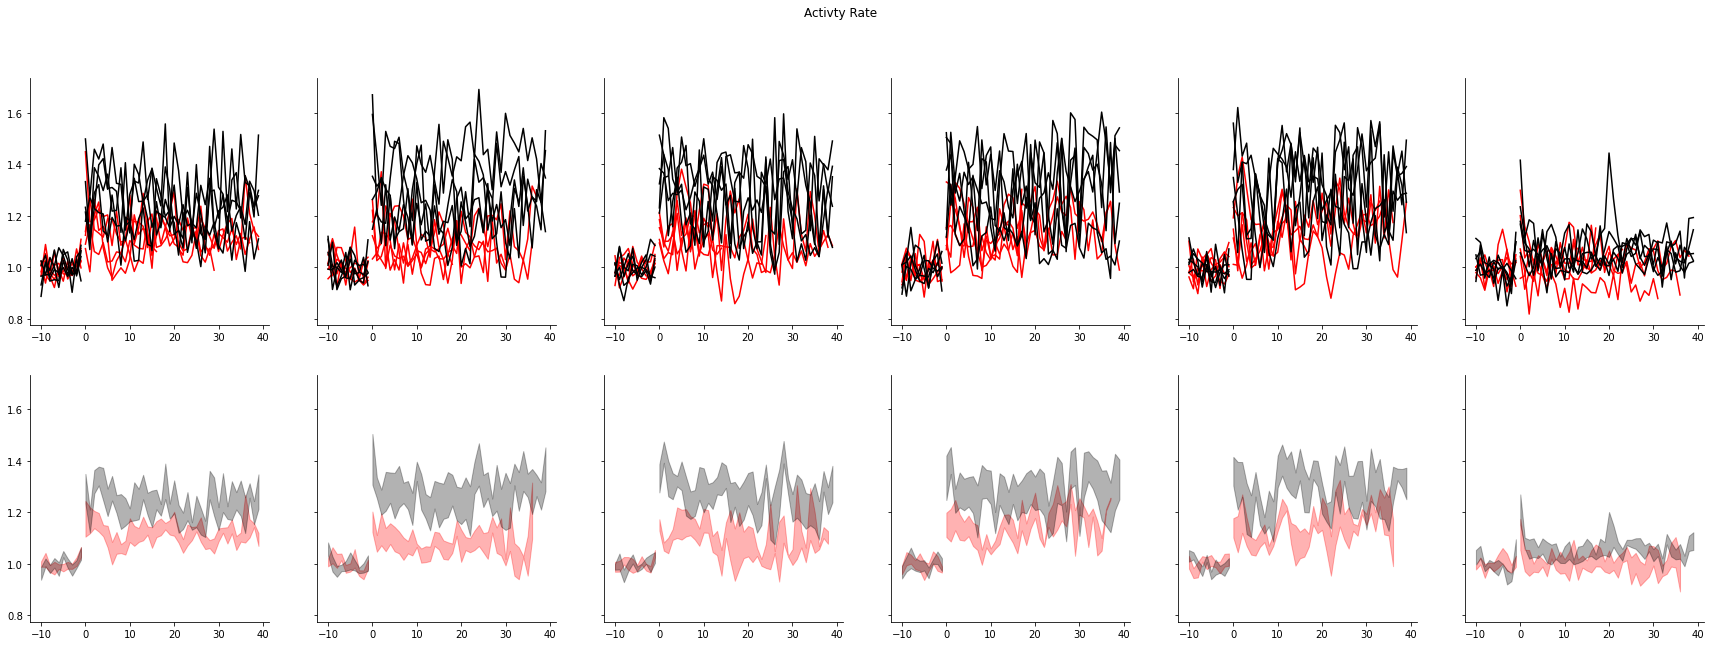

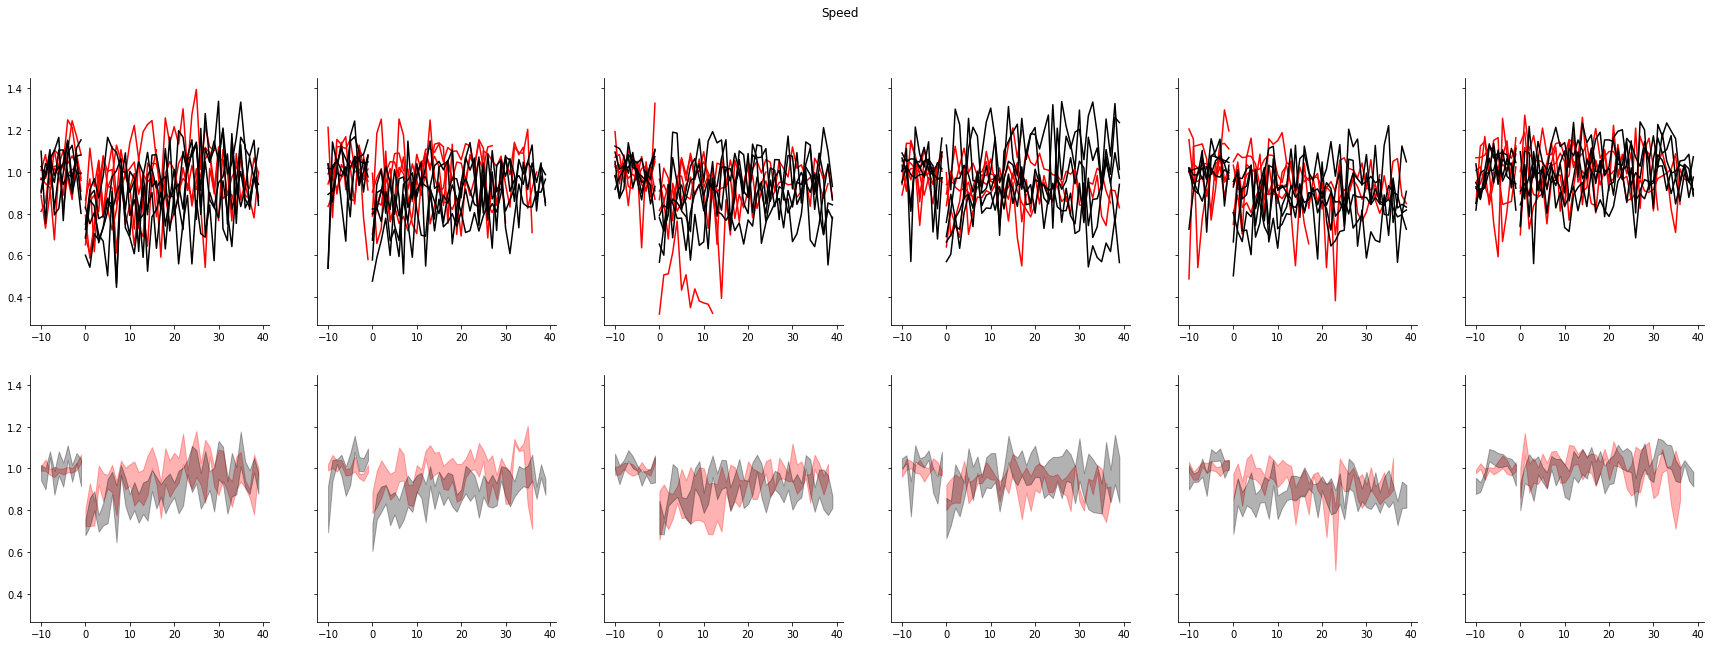

In [19]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
# fig_mu.savefig(os.path.join(figdir,'alltrials_block5_activity.pdf'),format='pdf')
# fig_speed.savefig(os.path.join(figdir,'alltrials_block5_speed.pdf'),format='pdf')


In [ ]:
ar = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=False, novel_only=False, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
<ipython-input-3-95d41453051a>:85: RuntimeWarning: Mean of empty slice
  mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could n

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


[0.61648594 1.63085136 1.78131505 1.74908512 1.65307894 1.53020948
 1.40799369 1.27492047 1.19767413 1.17888596 1.16254449 1.28752142
 1.38520805 1.43931185 1.49760688 1.51042378 1.47259599 1.39137432
 1.47391549 1.72046385 1.7570397  1.69624258 1.65551597 1.65835754
 1.50750434 1.73264551 1.45346599 1.66549777 1.69819039 1.63630794]
[0.61648594 1.63085136 1.78131505 1.74908512 1.65307894 1.53020948
 1.40799369 1.27492047 1.19767413 1.17888596 1.16254449 1.28752142
 1.38520805 1.43931185 1.49760688 1.51042378 1.47259599 1.39137432
 1.47391549 1.72046385 1.7570397  1.69624258 1.65551597 1.65835754
 1.50750434 1.73264551 1.45346599 1.66549777 1.69819039 1.63630794]
[0.61648594 1.63085136 1.78131505 1.74908512 1.65307894 1.53020948
 1.40799369 1.27492047 1.19767413 1.17888596 1.16254449 1.28752142
 1.38520805 1.43931185 1.49760688 1.51042378 1.47259599 1.39137432
 1.47391549 1.72046385 1.7570397  1.69624258 1.65551597 1.65835754
 1.50750434 1.73264551 1.45346599 1.66549777 1.69819039 1.63

In [19]:
ar.ko_data[ar.ko_mice[0]]['mu'][0].shape

(40, 30)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

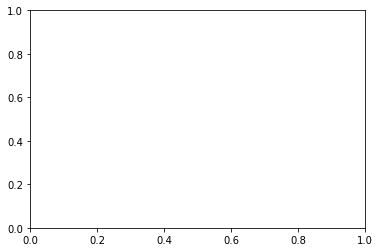

In [20]:
lr = ar.ctrl_data[ar.ctrl_mice[0]]['famnov'][0]
mu = np.nanmean(ar.ctrl_data[ar.ctrl_mice[0]]['mu'][0], axis=1)
fig, ax = plt.subplots()
ax.scatter(mu[lr==1,:].mean(axis=0), ar.ctrl_data[ar.ctrl_mice[0]]['place_cell_info'][0]['right']['SI'])

res = sp.stats.linregress(mu[lr==1,:].mean(axis=0), ar.ctrl_data[ar.ctrl_mice[0]]['place_cell_info'][0]['right']['SI'])

In [ ]:
mouse, day = ar.ko_mice[2], 3
lr = ar.ko_data[mouse]['famnov'][day]
mu = np.nanmean(ar.ko_data[mouse]['mu'][day], axis=1)
fig, ax = plt.subplots(2,2, figsize= [10,10], sharex = True)
ax[0, 0].scatter(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['right']['SI'])
ax[0, 0].vlines(1, 0, 1.2, color='red')
r,p = sp.stats.spearmanr(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['right']['SI'])
print('right', r, p)



ax[0,1].scatter(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['left']['SI'])
r,p = sp.stats.spearmanr(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['left']['SI'])
print('left', r, p)

In [ ]:
print(res)

In [ ]:


ctrl_mu, ctrl_bmu, speed, _, ctrl_lr = ar.make_plot_arr(ar.ctrl_data,0)
ko_mu, ko_bmu, speed, _, ko_lr = ar.make_plot_arr(ar.ko_data,0)

In [ ]:
print(ctrl_mu.shape, ko_mu.shape)
print(ctrl_bmu.shape, ko_bmu.shape)

In [ ]:
for i in range(5):
    fig,ax = plt.subplots(1,4, figsize= [20,5])
    fig.subplots_adjust(wspace=.5)
    combined_mu = np.log(np.concatenate((ctrl_bmu[i,:,:], ctrl_mu[i,:,:]), axis=0))
    mu = np.log(ctrl_mu[i,:,:])
    mask = ctrl_lr[i,:] ==1
    h = ax[0].imshow(combined_mu, vmin=-1, vmax=1, cmap='seismic')
    fig.colorbar(h,ax = ax[0])
    ax[0].set_yticks([0, 10, 20, 30, 40])
    ax[0].set_yticklabels([-10, 0, 10, 20, 30])
    ax[0].set_ylabel('Trials')
    ax[0].set_xlabel('Position')
    ax[0].set_title('All Trials')
    
    ax[1].imshow(mu[mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[1].set_ylabel('Trials')
    ax[1].set_xlabel('Position')
    ax[1].set_title('Familiar Trials')
    
    
    ax[2].imshow(mu[~mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[2].set_ylabel('Trials')
    ax[2].set_xlabel('Position')
    ax[2].set_title('Novel Trials')
    
    ax[3].plot(np.nanmean(mu[mask,:],axis=0))
    ax[3].plot(np.nanmean(mu[~mask,:], axis=0))
    
    fig.savefig(os.path.join(figdir,"%s_trial_heatmaps.pdf" % ctrl_mice[i]), format='pdf')

In [ ]:
for i in range(5):
    fig,ax = plt.subplots(1,4, figsize= [20,5])
    fig.subplots_adjust(wspace=.5)
    combined_mu = np.log(np.concatenate((ko_bmu[i,:,:], ko_mu[i,:,:]), axis=0))
    mu = np.log(ko_mu[i,:,:])
    mask = ctrl_lr[i,:] ==1
    h = ax[0].imshow(combined_mu, vmin=-1, vmax=1, cmap='seismic')
    fig.colorbar(h,ax = ax[0])
    ax[0].set_yticks([0, 10, 20, 30, 40])
    ax[0].set_yticklabels([-10, 0, 10, 20, 30])
    ax[0].set_ylabel('Trials')
    ax[0].set_xlabel('Position')
    ax[0].set_title('All Trials')
    
    ax[1].imshow(mu[mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[1].set_ylabel('Trials')
    ax[1].set_xlabel('Position')
    ax[1].set_title('Familiar Trials')
    
    
    ax[2].imshow(mu[~mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[2].set_ylabel('Trials')
    ax[2].set_xlabel('Position')
    ax[2].set_title('Novel Trials')
    
    ax[3].plot(np.nanmean(mu[mask,:],axis=0))
    ax[3].plot(np.nanmean(mu[~mask,:], axis=0))
    
    fig.savefig(os.path.join(figdir,"%s_trial_heatmaps.pdf" % ko_mice[i]), format='pdf')

<ipython-input-80-8efc1cee4cd0>:3: RuntimeWarning: Mean of empty slice
  ax[1].imshow(np.nanmean(ko_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
<ipython-input-80-8efc1cee4cd0>:4: RuntimeWarning: Mean of empty slice
  ax[2].imshow(np.nanmean(ctrl_mu, axis=0) - np.nanmean(ko_mu, axis=0), cmap='seismic', vmin=-1, vmax = 1)


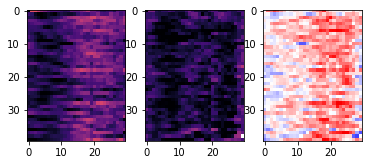

In [80]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(np.nanmean(ctrl_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
ax[1].imshow(np.nanmean(ko_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
ax[2].imshow(np.nanmean(ctrl_mu, axis=0) - np.nanmean(ko_mu, axis=0), cmap='seismic', vmin=-1, vmax = 1)

<ipython-input-81-336e5a105740>:6: RuntimeWarning: Mean of empty slice
  mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=0))


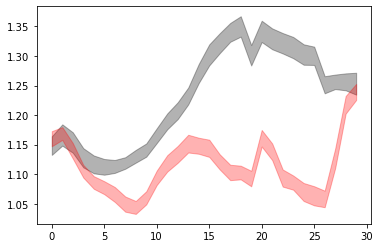

In [81]:
fig, ax = plt.subplots(sharey = True)
x = np.arange(30)
mu, sem = ar.mu_sem(np.nanmean(ctrl_mu, axis=0))
ax.fill_between(x, mu-sem, mu+sem, alpha = .3, color='black')

mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=0))
ax.fill_between(x, mu-sem, mu+sem, alpha = .3, color='red')

In [51]:
t,p = sp.stats.ranksums(np.nanmean(ko_mu[:,10:],axis=-1), np.nanmean(ctrl_mu[:,10:],axis=-1))
print(t,p)

-0.5222329678670935 0.6015081344405899


In [ ]:
# plot change in activity rate as a function of position

# correlate change in activity rate with spatial information or just whether or not its a place cell (both familiar and novel)

# check raw data to make sure there's no funny business